In [1]:
import random

from logic_gates import run_evolution_strong_selection, run_random_walk, Circuit
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import concurrent.futures
from goals import and_funct
import pickle

In [2]:
class IsomorphismCounter:

    def __init__(self):
        self.counter = defaultdict(Counter)

    def add(self, network, size: int):
        for key in self.counter:
            if key.is_isomorphic(network, pruned=True):
                self.counter[key][size] += 1
                self.counter[key]["total"] += 1
                return key
        self.counter[network][size] += 1
        self.counter[network]["total"] += 1
        return network

    def get_networks(self):
        return self.counter.keys()

    def get_number_by_size(self, size: int):
        return {key: value[size] for key, value in self.counter.items()}

    def get_number_networks_total(self):
        return {key: value['total'] for key, value in self.counter.items()}

def worker(args):
    args[0](*args[0:])

def run_in_parallel(function, axis, size, isomorphism_counter, possible_genomes, *args):
    total_times = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_results = [executor.submit(function, *args[:-1], Circuit(2, random.choice(possible_genomes)), args[-1]) for _ in range(50)]
        for f in tqdm(concurrent.futures.as_completed(future_results)):
            time, circuit, fitness = f.result()
            axis.plot(fitness)
            total_times.append(len(time))
            isomorphism_counter.add(circuit, size)
    return total_times

2


0it [00:00, ?it/s]

TypeError: run_evolution_strong_selection() missing 1 required positional argument: 'm_max'

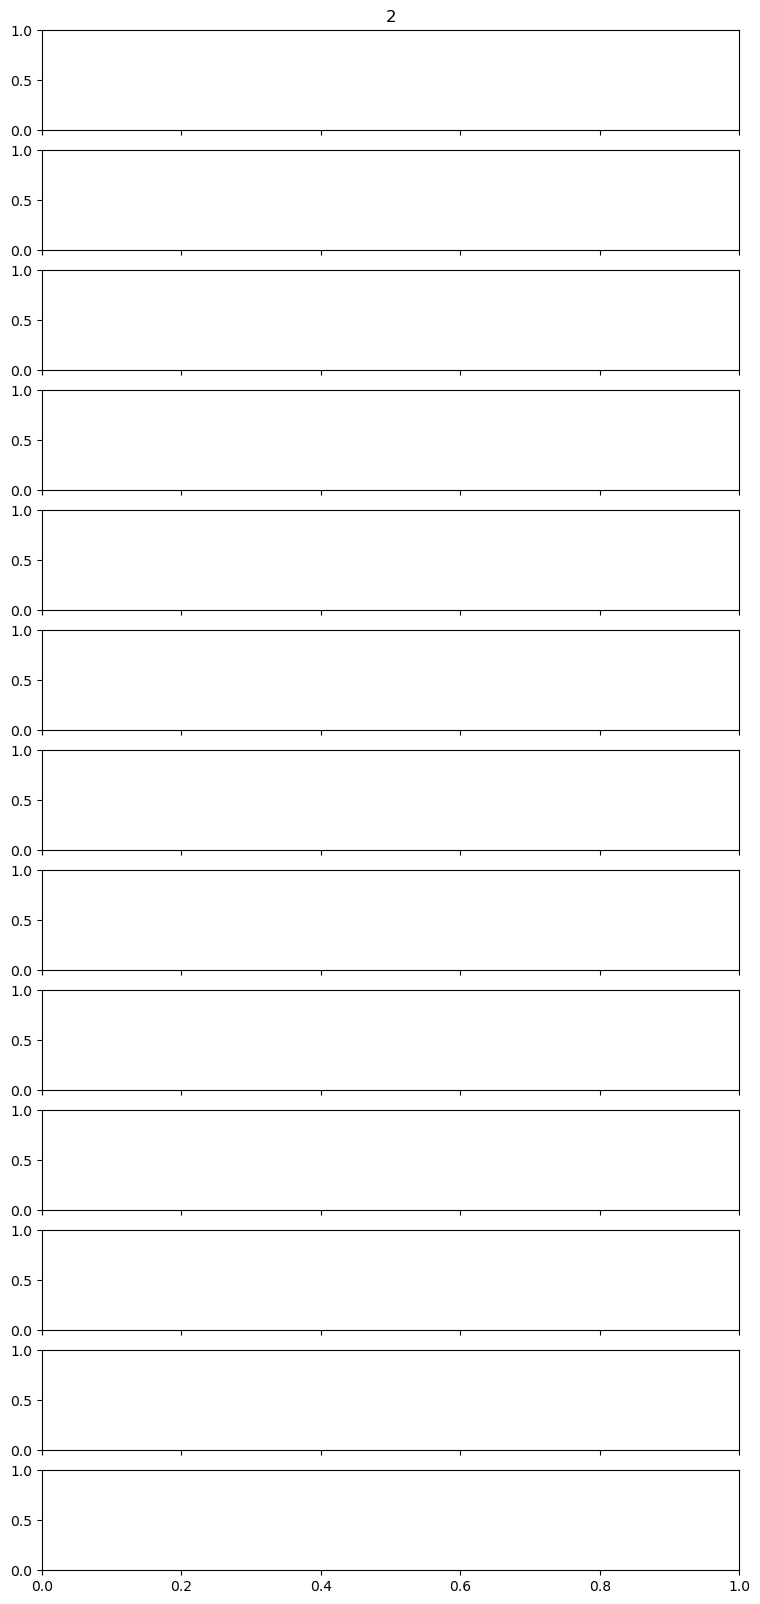

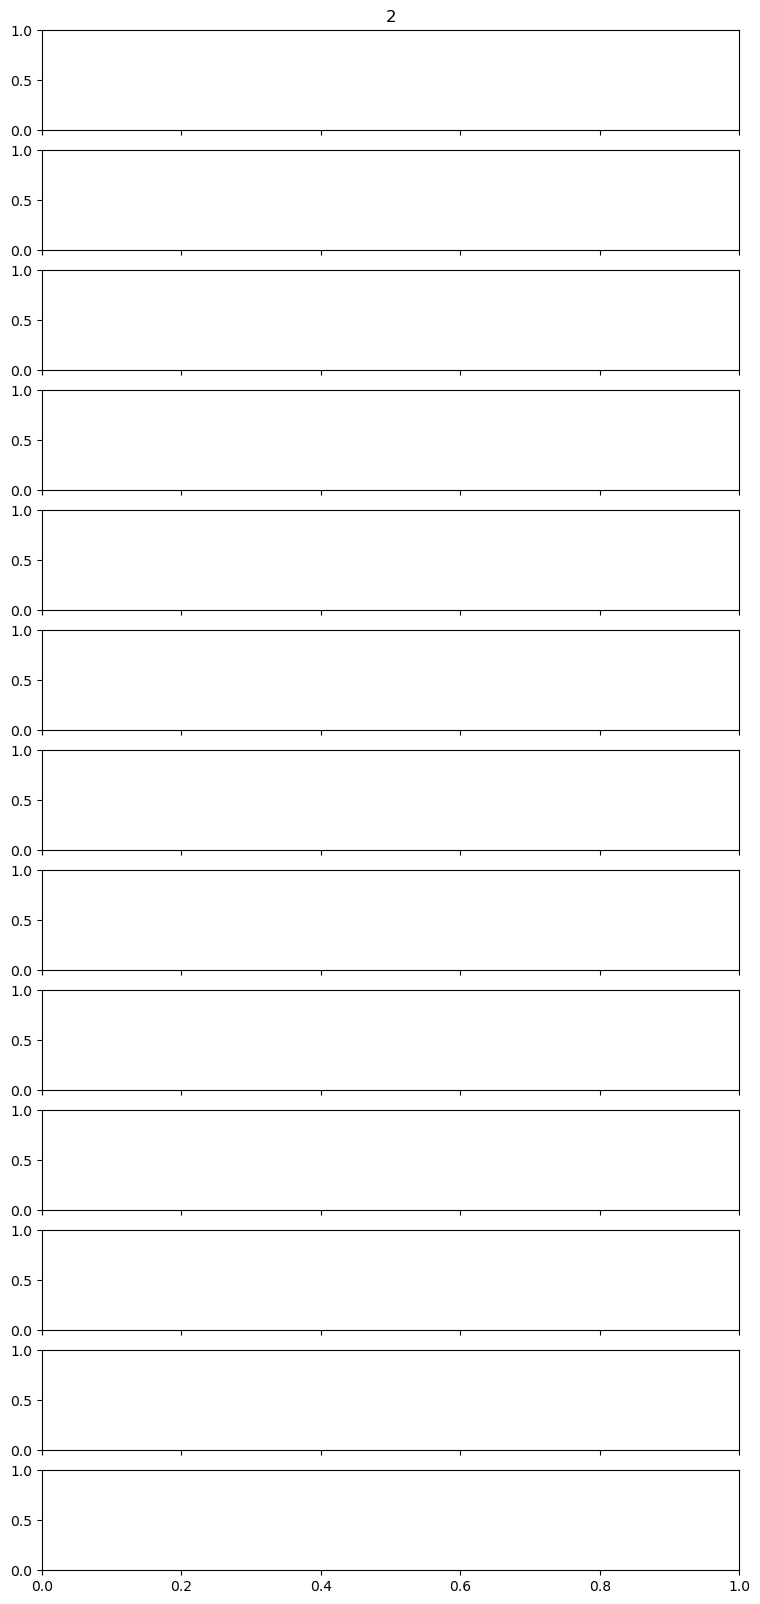

In [3]:
sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
random.seed()
fig_trajectory, ax_trajectories = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
fig_histogram, ax_histograms = plt.subplots(len(sizes), 1, sharex=True, sharey=True, figsize=(9, 20))
means = []
medians = []
stds = []
isomorphism_counter = IsomorphismCounter()
num_trials = 100
for size, ax_trajectory, ax_histogram in zip(sizes, ax_trajectories, ax_histograms):
    ax_trajectory.set_title(size)
    ax_histogram.set_title(size)
    print(size)
    with open('zero_fitness_genome_files/and/size_'+str(size)+'.pickle', 'rb') as f:
        zero_fit_genomes = pickle.load(f)
    genomes = random.choices(zero_fit_genomes, k=5)
    total_times = []
    for genome in genomes:
        times = run_in_parallel(run_evolution_strong_selection, ax_trajectory, size, isomorphism_counter, genomes, and_funct, 1000, 0.1, 10000)
        ax_histogram.hist(times, 20)
        total_times.append(times)
    total_times_array = np.array(total_times)
    medians.append(np.median(total_times_array, axis=1))
    print("Median:" + str(medians[-1]))
    means.append(total_times_array.mean(axis=1))
    print("Mean:" + str(means[-1]))
    stds.append(total_times_array.std(axis=1))
    print("STD:" + str(stds[-1]))
fig_trajectory.savefig('trajectories.png', dpi=1200)
fig_histogram.savefig('histogram_fixations100.png')
plt.show()

In [ ]:
means = np.array(means)
stds = np.array(stds)
medians = np.array(medians)

fig, ax = plt.subplots(1, 1, tight_layout=True)
for i in range(means.shape[1]):
    ax.errorbar(x=sizes, y=means[:,i], yerr=np.array(stds[:,i])/np.sqrt(1000))
ax.set_title("Mean Number of Mutations Until Fixation")
plt.show()

fig, ax = plt.subplots(1, 1, tight_layout=True)
for i in range(medians.shape[1]):
    ax.plot(sizes, medians[:,i])
ax.set_title("Median Number of Mutations Until Fixation")
plt.show()

In [ ]:
network_counter = isomorphism_counter.counter
for key, value in network_counter.items():
    if value['total'] > 4:
        print(value)
        key.plot_network(prune=True)
        plt.show()

In [ ]:
list_unique_networks = list(isomorphism_counter.counter.keys())
figs, axs = plt.subplots(5, 1, sharex=True, sharey=True)
for ax, network in zip(axs, list_unique_networks[:5]):
    ax.plot(sizes, [isomorphism_counter.get_number_by_size(size)[network] for size in sizes])